# 4. Modeling with Lines

In this chapter, we look at a common motif in statistics: **linear models**.

This chapter will cover the following topics:

- Simple linear regression
- NegativeBinomial regression
- Robust regression
- Logistic regression
- Variable variance
- Hierarchical linear regression
- Multiple linear regression


## 4.1 Simple linear regression

Many problems in science, engineering, and business have a linear form.
That is, we have a variable, $X$, and we want to model or predict a
variable, $Y$, and the relationship between element of $X$ and $Y$
is a **linear** relationship.

In the simplest scenario, simple linear regression, both $X$ and $Y$
are uni-dimensional continuous **random** variables.

Typically, we use the following terminology:

- $Y$ is the **dependent**, **predicted**, or **outcome** variable
- $X$ is the **independent**, **predictor** or **input** variable

Some typical situations where the linear regression model can be use are:

- Model the relationship between soil salinity and crop productivity.
Then answer questions like "Is this relationship linear?" or "How
strong is this relationship?"
- Find a relationship between the average chocolate consumption by
country and the number of Nobel laureates in that country, and then
understand why that relationship could be **spurious**.
- Predict the gas bill (used for heating and cooking) of your house
by using the solar radiation from the local weather report. How
accurate is this prediction?

In _Chapter 2_, we saw the Normal model. We can think of this model
as follows:

$$
\begin{align*}
\mu &\sim some\ prior \\
\sigma &\sim some\ other\ prior \\
Y &\sim \mathcal{N}(\mu, \sigma)
\end{align*}
$$

The main idea of linear regression is to extend this model by adding
a predictor variable $X$ to the estimation of mean, $\mu$.

$$
\begin{align*}
\alpha &\sim a\ prior \\
\beta &\sim another\ prior \\
\sigma &\sim some\ other\ prior \\
\mu &= \alpha + \beta X \\
Y &\sim \mathcal{N}(\mu, \sigma)
\end{align*}
$$

This model says that a linear relationship exists between $X$
and $Y$. However, that relationship is **not deterministic**
because of the noise term, $\sigma$.

Additionally, this model states that the mean of $Y$ is a linear
function of $X$ with **intercept** $\alpha$ and **slope** $\beta$.
However, because we **do not know** the values of $\alpha$, $\beta$,
or $\sigma$, we set prior distributions over them.

Typically, when setting priors for linear models, we **assume** that
the priors are **independent**. Because the priors are independent, we
model the problem using three different priors instead of a single,
joint prior.

Additionally, because $\sigma$ is a positive number, it is common
to use the distribution:

- HalfNormal
- Exponential
- HalfCauchy
- And so on

The values for the intercept can vary widely from one problem to
another and for different domains. In the experience of the author,

- $\alpha$ is usually centered around 0 and has a standard deviation
no larger than 1
- It is easier to have an informed prior for the slope, $\beta$
- For $\sigma$, we can set it to a large value on the scale of $Y$
For example, twice the value of its standard deviation.

We should be cautious of using observed data to determine
("guesstimate") priors. It is usually fine to use the observed data
if we want to avoid very restrictive priors; however, a more general
principle is that if we don't have much knowledge of a parameter,
it makes sense to ensure that our prior is **vague**.

How do we make our priors more informative? We need to get informative
priors from our **domain knowledge**.

**Extending the Normal Model**

In summary, "a linear regression model is an extension of the
Normal model where the mean is computed as a linear function of a
predictor variable."

## 4.2 Linear bikes

We now have a general idea of Bayesian linear models. Let's try
to cement these ideas with an example.

We have a record of temperatures and the number of bikes rented in a
city. We want to model the relationship between temperature and the
number of bikes rented.

Here's a scatter plot of these two variables from the bike sharing
dataset from the UCI Machine Learning Repository.

The full dataset contains 17,379 records. Each record has 17 variables.

We use a smaller dataset: 359 records and only two variables:
`temperature` (in degrees Celsius) and `rented` (the number of
rented bikes.

In [1]:
# Begin with our general imports
import cytoolz.curried as ctc

In [2]:
# Import our general data analysis tools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Import our SciPy tools
from scipy.interpolate import PchipInterpolator
from scipy.stats import linregress

In [4]:
# Import PyMC and ancillary tools
import arviz as az
import pymc as pm
import preliz as pz
import xarray as xr

In [5]:
# Set values for plotting and for generating random variables
az.style.use('arviz-grayscale')

# Plotting defaults
from cycler import cycler
default_cycler = cycler(color=['#000000', '#6a6a6a', '#bebebe', '#2a2eec'])
plt.rc('axes', prop_cycle=default_cycler)
plt.rc('figure', dpi=300)

# Set a random seed
rng = np.random.default_rng(seed=123)

Let's create a scatter plot of `rented` versus `temperature`.

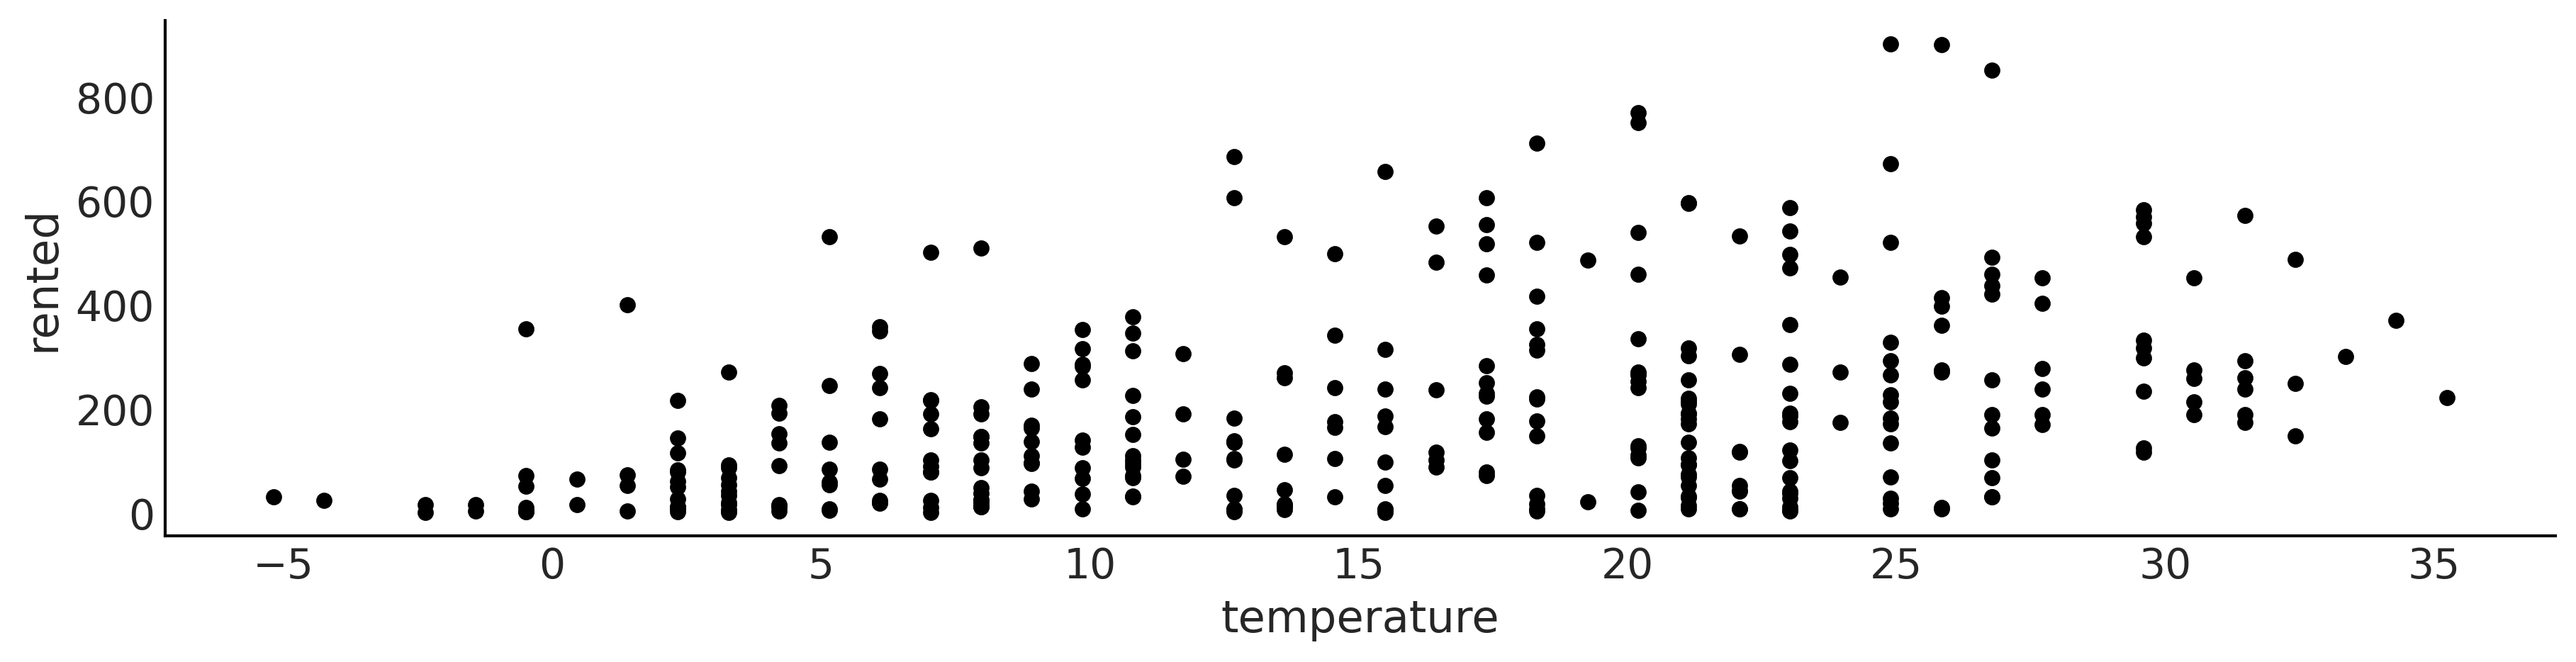

In [6]:
bikes = pd.read_csv('./data/bikes.csv')
bikes.plot(x='temperature', y='rented', figsize=(12, 3), kind='scatter')
plt.show()

By "squinting", one can visualize a linear relationship between
the number of bikes rented and outdoor temperature; however, we
want to understand that relationship better.

For our first model, we'll create a linear model using PyMC.

In [7]:
with pm.Model() as model_lb:
    alpha = pm.Normal('alpha', mu=0, sigma=100) ## Very flat
    beta = pm.Normal('beta', mu=0, sigma=10) ## Pretty flat
    sigma = pm.HalfCauchy('sigma', 10)
    mu = pm.Deterministic('mu', alpha + beta * bikes.temperature)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=bikes.rented)
    idata_lb = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Here's a Kruschke diagram of a proposed model

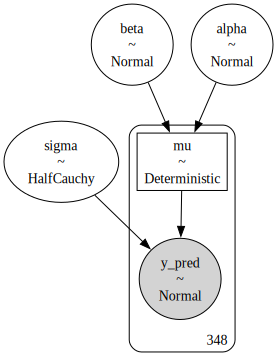

In [8]:
pm.model_to_graphviz(model_lb)

This model is like a Normal model; however, the mean is modeled
as a **linear function** of the temperature. The intercept of the
linear model is $\alpha$, the slope of the linear model is $\beta$,
and the "noise" term is $\sigma$.

The new aspect to this model is that the model for $\mu$ is
**deterministic**; that is, given values for $\alpha$ and $\beta$
(and our temperature data), the value for $\mu$ is computed.

This "deterministic variable" technique may seem useless; however,
by defining this variable in our model (even though it is "unnecessary")
we can include it in our `InferenceData` for later use. Notice that
$\mu$ is a vector with the same length as `bikes.temperature, which
is the same number of records in the dataset.

### 4.2.1 Interpreting the posterior mean

Let's generate a posterior plot but omit the deterministic variable,
$\mu$, because including it would generate one plot for each
temperature value.

To accomplish this goal, we can either explicitly list variables to
include as values of the `var_names` parameter, or we can exclude
a variable by prefacing the excluded variable by a tilde ('~').

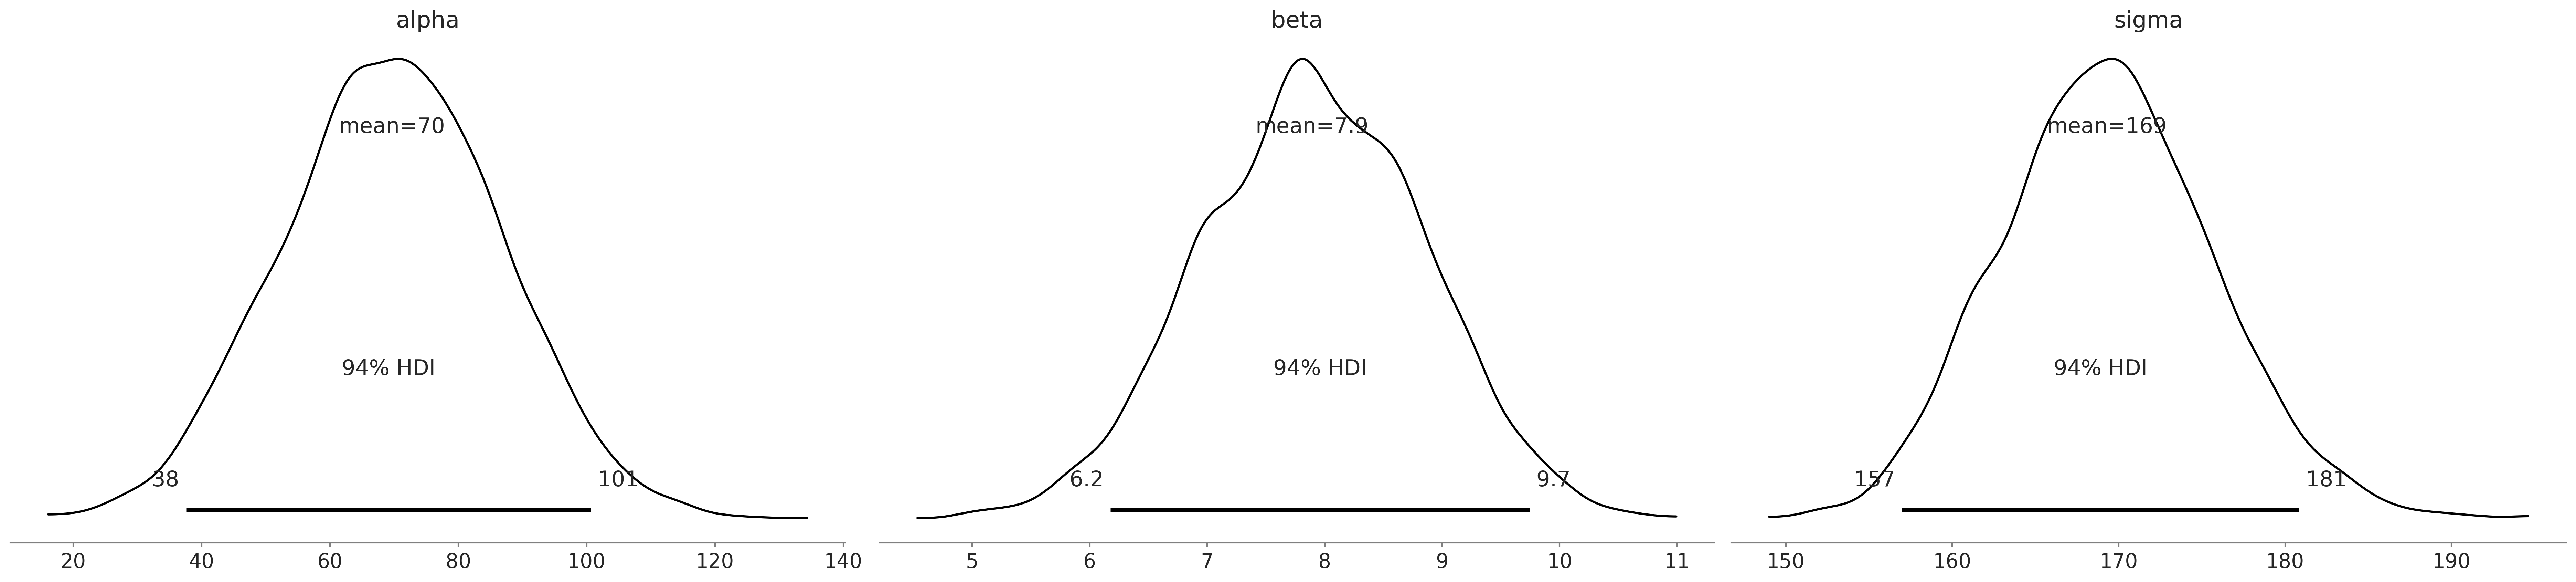

In [9]:
az.plot_posterior(idata_lb, var_names=['~mu'])
plt.show()

If we read the means of each distribution, our equation for $\mu$
becomes $\mu = 69 + 7.9 \mathcal(X)$. In words, when the temperature
is 0, the number of rented bikes is 69. For each degree above 0, the
number of rented bikes increases by 7.9. Specifically, for a
temperature of 28 C, we expect to see 278 bikes rented.

This equation captures our expectations; however, we have uncertainty
about the number of rented bikes because our value for $\sigma$ has a
mean value of 170. Consequently, even though we expect 278 bikes rented,
our uncertainty means that we should not be surprised by renting
anywhere from 100 to 500 bikes.

Let's create a few plots to help us visualize the combined uncertainty
of these parameters. We'll start with two plots for the mean. Both
curves plot the mean number of rented bikes as a function of
temperature.

The left panel takes 50 samples from the posterior and plots them as
individual lines. The right panel takes **all** available posterior
samples for $\mu$ and uses them to compute the 94% HDI.


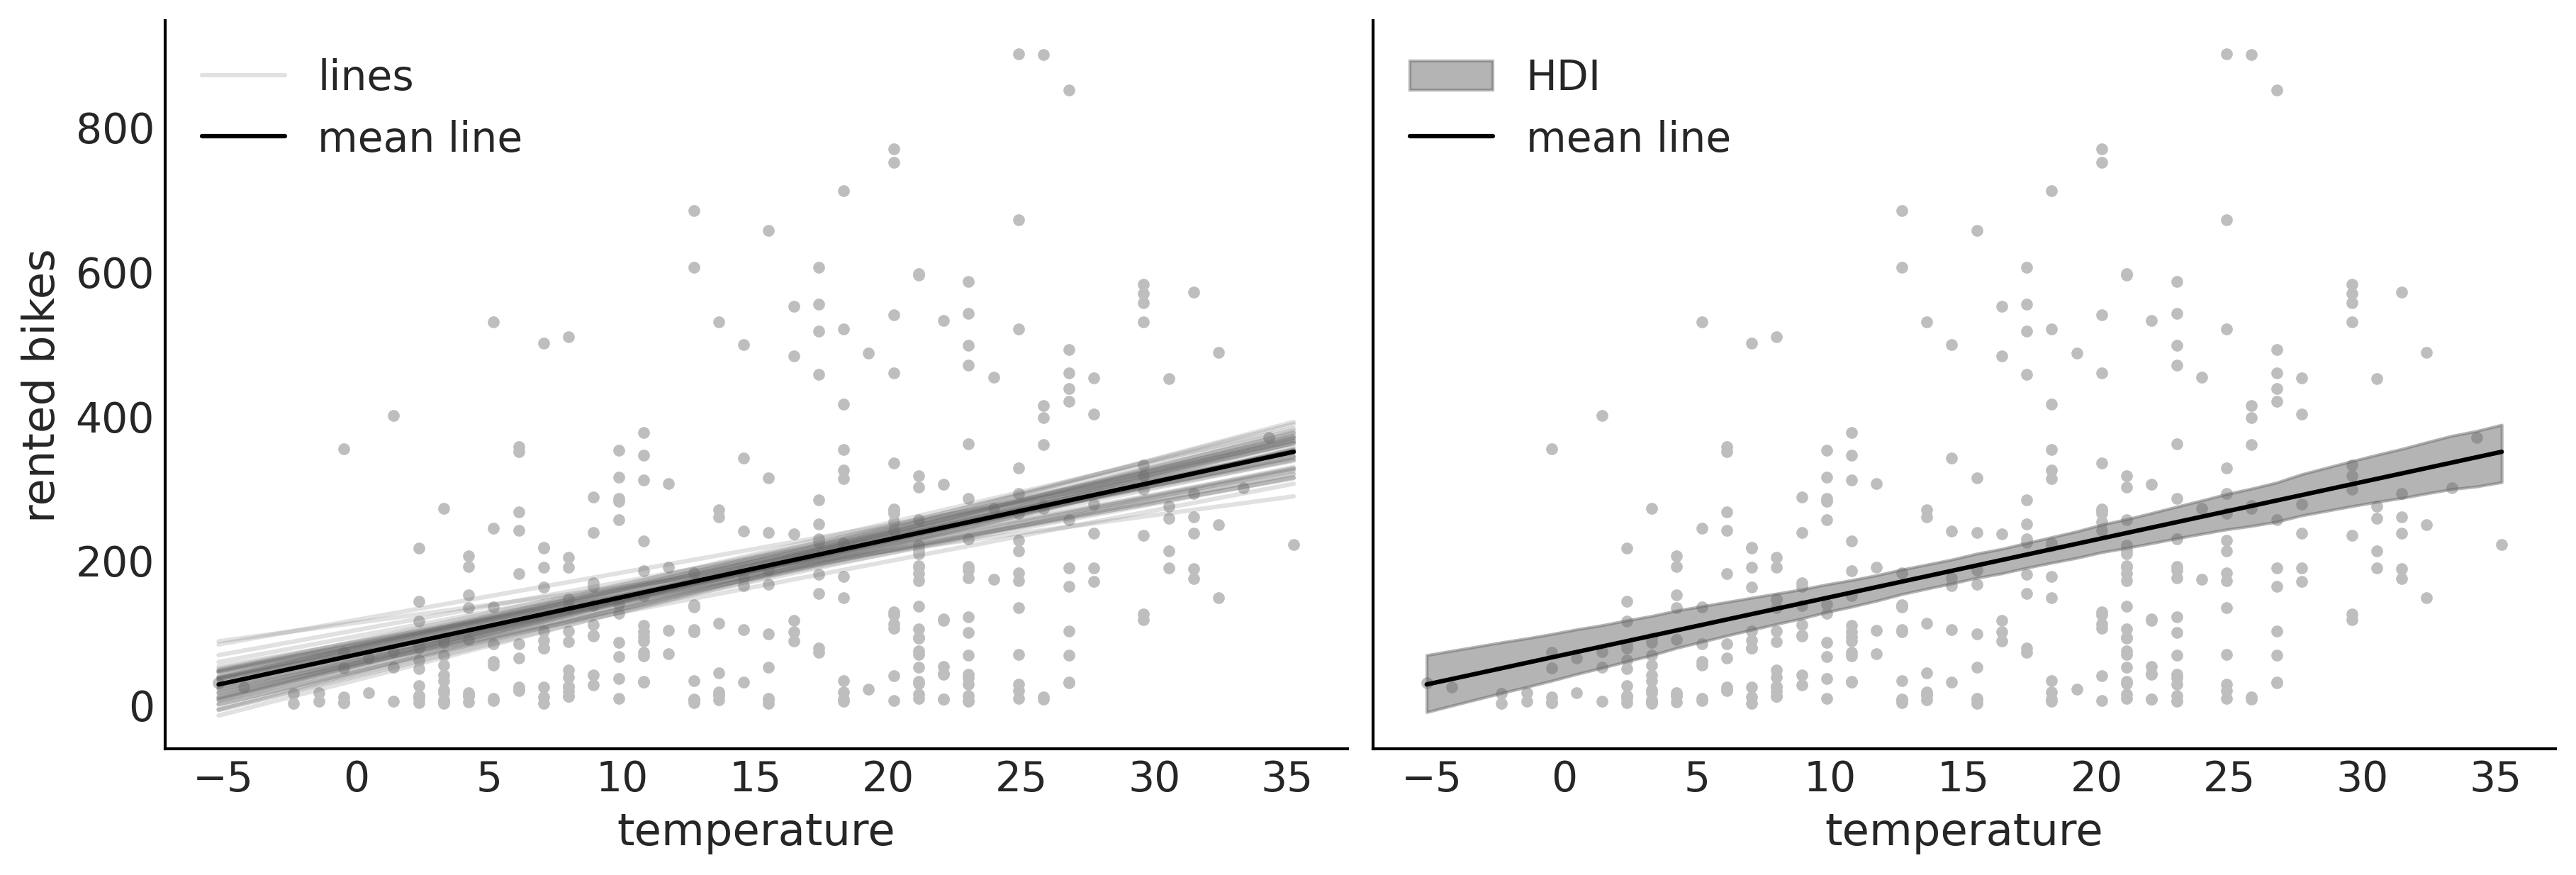

In [10]:
# From the book website
posterior = az.extract(idata_lb, num_samples=50)
x_plot = xr.DataArray(
    np.linspace(bikes.temperature.min(), bikes.temperature.max(), 50),
    dims='plot_id',
)

mean_line = posterior['alpha'].mean() + posterior['beta'].mean() * x_plot
lines = posterior['alpha'] + posterior['beta'] * x_plot
hdi_lines =az.hdi(idata_lb.posterior['mu'])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].plot(bikes.temperature, bikes.rented, 'C2.', zorder=-3)
lines_ = axes[0].plot(x_plot, lines.T, c='C1', alpha=0.2, label='lines')
plt.setp(lines_[1:], label='_')
axes[0].plot(x_plot, mean_line, c='C0', label='mean line')
axes[0].set_xlabel('temperature')
axes[0].set_ylabel('rented bikes')
axes[0].legend()

axes[1].plot(bikes.temperature, bikes.rented, 'C2.', zorder=-3)
idx = np.argsort(bikes.temperature.values)
axes[1].fill_between(
    bikes.temperature.values[idx],
    hdi_lines['mu'][:, 0][idx],
    hdi_lines['mu'][:, 1][idx],
    color='C1',
    label='HDI',
    alpha=0.5,
)
axes[1].plot(x_plot, mean_line, c='C0', label='mean line')
axes[1].set_xlabel('temperature')
axes[1].legend()

plt.show()

These plots essentially convey the same information. However, the
left-hand plot represents uncertainty as a set of lines and the
right-hand plot represents uncertainty as a shaded area.

Notice that if you repeat the plots, you will get different lines
because we are sampling from he posterior. The shaded area, in the
right-hand plot, remains the same because we calculate the HDI from
all available posterior samples.

However, if we go further and refit the model, we will get new lines
in the left-hand plot **and** we may get a different shaded region in
the right-hand plot.

The different between runs will probably be very small; if not, you
may need to increase the number of drawn or there is something funny
(an error) about your model and sampling. (See Chapter 10 for guidance.)

We are showing these two plots to:

- Illustrate different ways to represent uncertainty

Which way is better? As frustrating as it is, "It depends."

The shaded area is:

- A good option (and is very common)
- Simple to compute
- Simple to interpret

But it **does not** show individual posterior samples.

For example,

|      |                                                   |
|------|---------------------------------------------------|
| If   | Most of the lines span a certain region           |
| But  | A few lines have **very high** slopes             |
| Then | The shaded HDI region could hide these exceptions |

Finally, if you want to show individual samples from the posterior,
it may be a good idea to animate them if you show theme in a
presentation or a video.



These plots also illustrate different ways to extract information
from the posterior. For example, the call to `az.extract()` takes
the `chain` and `draw` values and stacks them in a single `sample`
dimension. This stacking can be useful for later processings.

The AI response to this question,
"what is stacking chain and draw dimensions pymc", is:

In PyMC, "stacking chain and draw dimensions" refers to the process
of combining the "chain" dimension (representing different Markov
Chain Monte Carlo (MCMC) chains) and the "draw" dimension (representing
individual samples within each chain) into a single, flattened dimension,
essentially creating a single array where each element corresponds to a
single sample across all chains, effectively treating all chains as one
large sample set.

### Key points about stacking chain and draw dimensions: ###

#### Purpose: ####

This technique is often used when you want to analyze the posterior
distribution without considering the individual chains, allowing
for simpler data manipulation and visualization.

#### Function in PyMC: ####

To achieve this stacking, you can use the `arviz.InferenceData.stack`
method, typically with arguments like `sample=("chain", "draw")` to
specify which dimensions should be combined.

##### When to use it: #####

- When comparing different models based on their posterior
distributions without considering chain-specific variations.
- When visualizing posterior distributions with plots that
expect a single sample dimension.

#### Important considerations: ####

##### Convergence check: #####

Before stacking chains, ensure that the chains have converged
properly, as stacking can mask potential convergence issues.

##### Alternative approaches: #####

If you need to analyze chain-specific information, consider
using methods that explicitly handle the chain dimension separately.

Additionally, `num_samples` is used to ask for a subsample from the posterior.

### 4.2.2 Interpreting the posterior predictions

We've seen haw we can sample from the posterior. But what if we want
to make a **prediction**. For this purpose, we do posterior
predictive sampling.

In [11]:
# Sample from the posterior to make predictions and add these points
# to our `InferenceData`.
pm.sample_posterior_predictive(idata_lb, model=model_lb, extend_inferencedata=True)

Sampling: [y_pred]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Let's plot our predictions. We'll include

- The mean number of rented bikes (black line)
- The central 505 range of rented bikes (dark gray band)
- The central 94% of rented bikes (light gray band)

Finally, notice that the posterior predictive samples predict
a **negative** number of rented bikes for low temperatures. This
result is a consequence of using the Normal distribution for the
likelihood in `model_lb`. We could just cut out this "invalid"
data; however, in the next section, we'll see how we can easily
improve this model to avoid nonsensical predictions.

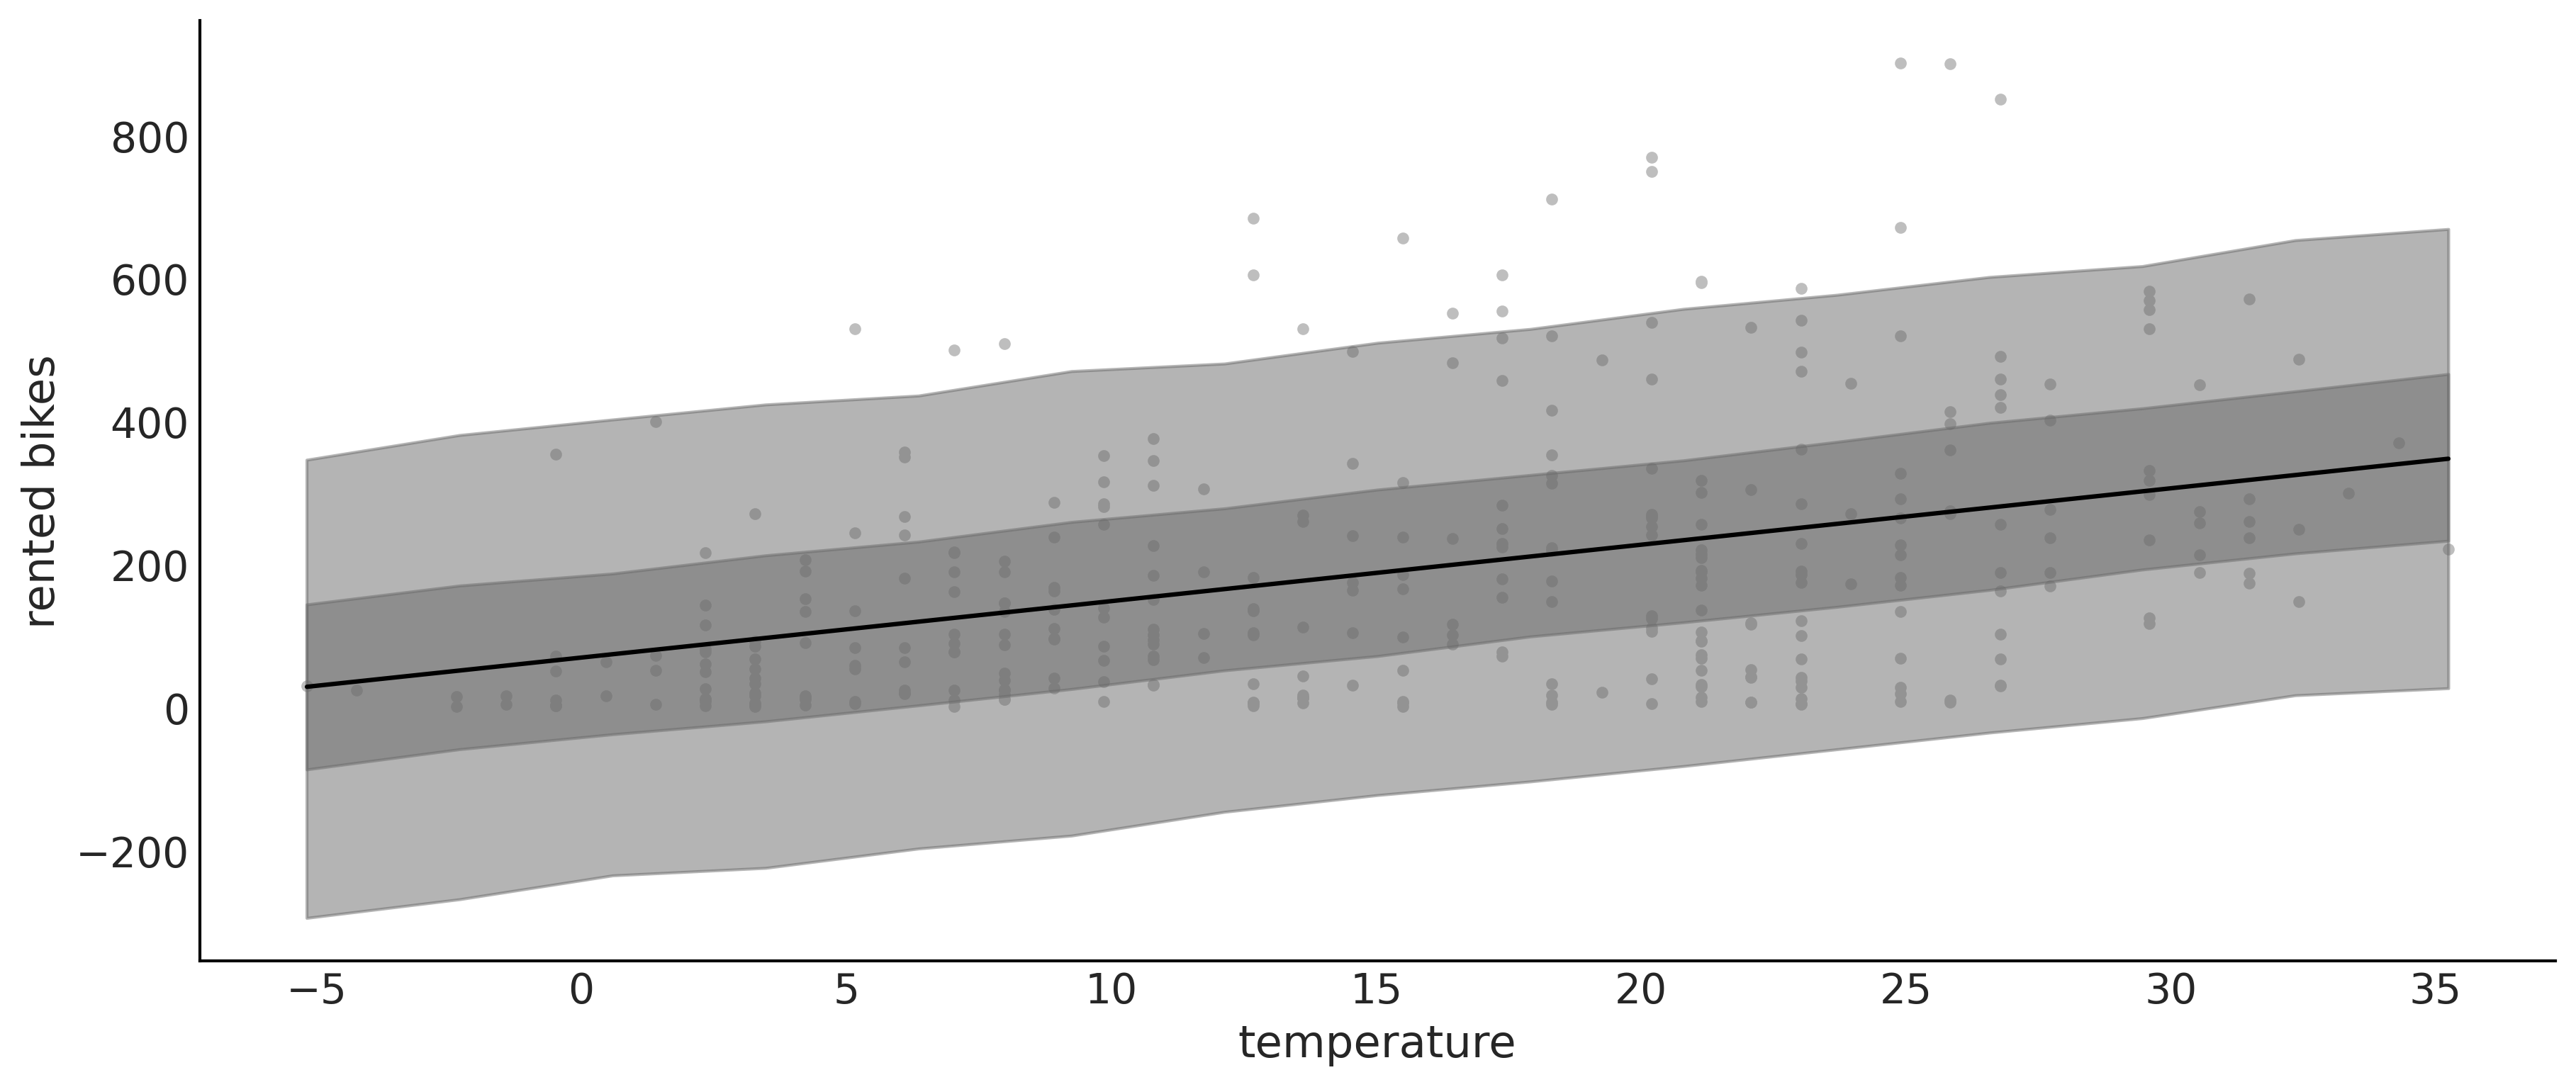

In [12]:
# Plot our predictions
mean_line = idata_lb.posterior['mu'].mean(('chain', 'draw'))
temperatures = np.random.normal(bikes.temperature.values, 0.01)
idx = np.argsort(temperatures)

x = np.linspace(temperatures.min(), temperatures.max(), 15)
y_pred_q = (
    idata_lb.posterior_predictive['y_pred']
            .quantile([0.03, 0.97, 0.25, 0.75], dim=['chain', 'draw'])
)
y_hat_bounds = iter(
    [PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
     for i in range(4)]
)

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(bikes.temperature, bikes.rented, 'C2.', zorder=-3)
ax.plot(bikes.temperature[idx], mean_line[idx], c='C0')

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color='C1', alpha=0.5)

ax.set_xlabel('temperature')
ax.set_ylabel('rented bikes')

plt.show()

## 4.3 Generalizing the linear model

The linear model we have been using is a special case of a more
general model, the **Generalized Linear Model (GLM)**.

We can write a Bayesian GLM like:

$$
\begin{align}
    \alpha &\sim a \ prior \\
    \beta &\sim another \ prior \\
    \theta &\sim some \ prior \\
    \mu &= \alpha + \beta X \\
    Y &\sim \phi(f(\mu), \theta)
\end{align}
$$

where

- $\phi$ is an arbitrary **distribution**
- $\theta$ represents **any auxiliary** parameter (like \sigma for a Normal distribution)

$f$ is usually called the inverse link function. Typical inverse link functions are:

| When $phi$ is... | Then $f$, the inverse link function is... |
| ---------------- | ----------------------------------------- |
| Normal | The identity function |
| Gamma or NegativeBinomial | The exponential function |

What is the reason for needing $f$?

Because the linear model is generally defined on the real line
but $mu$ or its equivalent may be defined on a **different** domain.

Here is a good exercise:

- Create a table
- Everytime you see a new GLM, add a line indicating $phi$, $theta$,
and $f$, and, perhaps, some notes about when this GLM is used.